<a href="https://colab.research.google.com/github/BaronVonBussin/Stuff/blob/main/Example_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arviz

Output()

Output()


Results Summary:
True Population Size: 500
Estimated Population Size: 583.7
95% CI: (303.2, 961.7)

True Detection Probability: 0.30
Estimated Detection Probability: 0.28
95% CI: (0.15, 0.49)


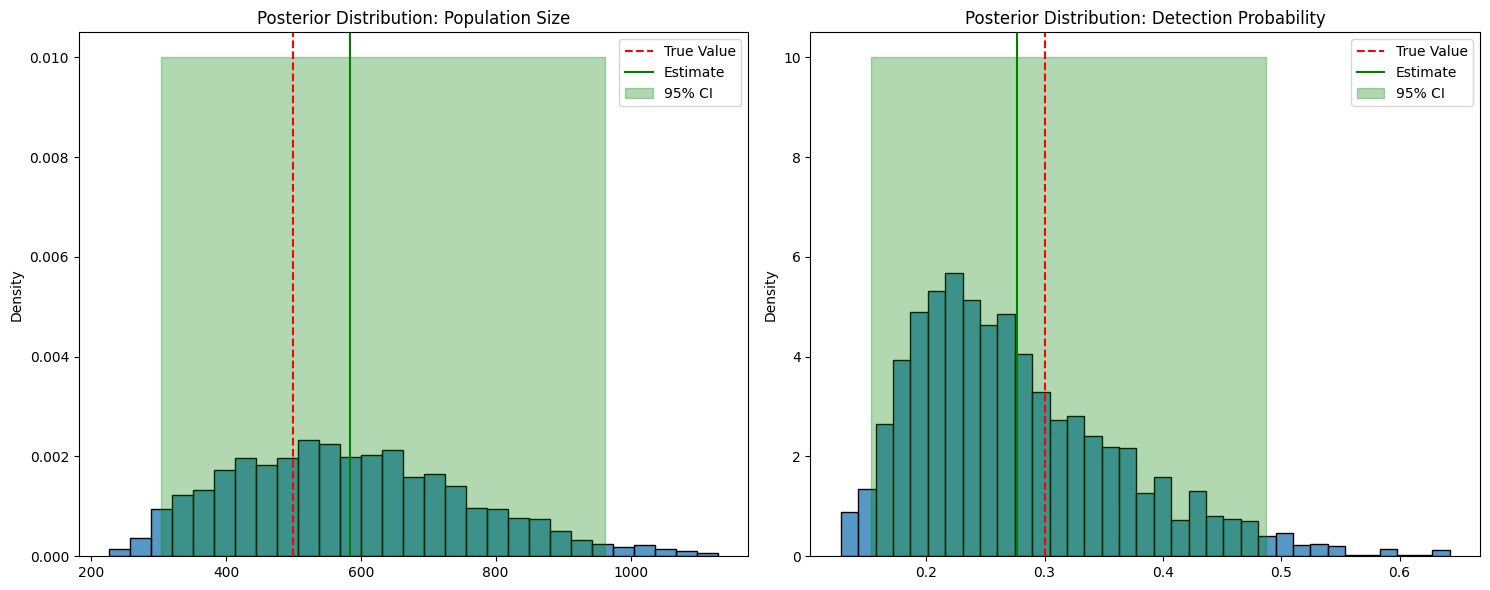

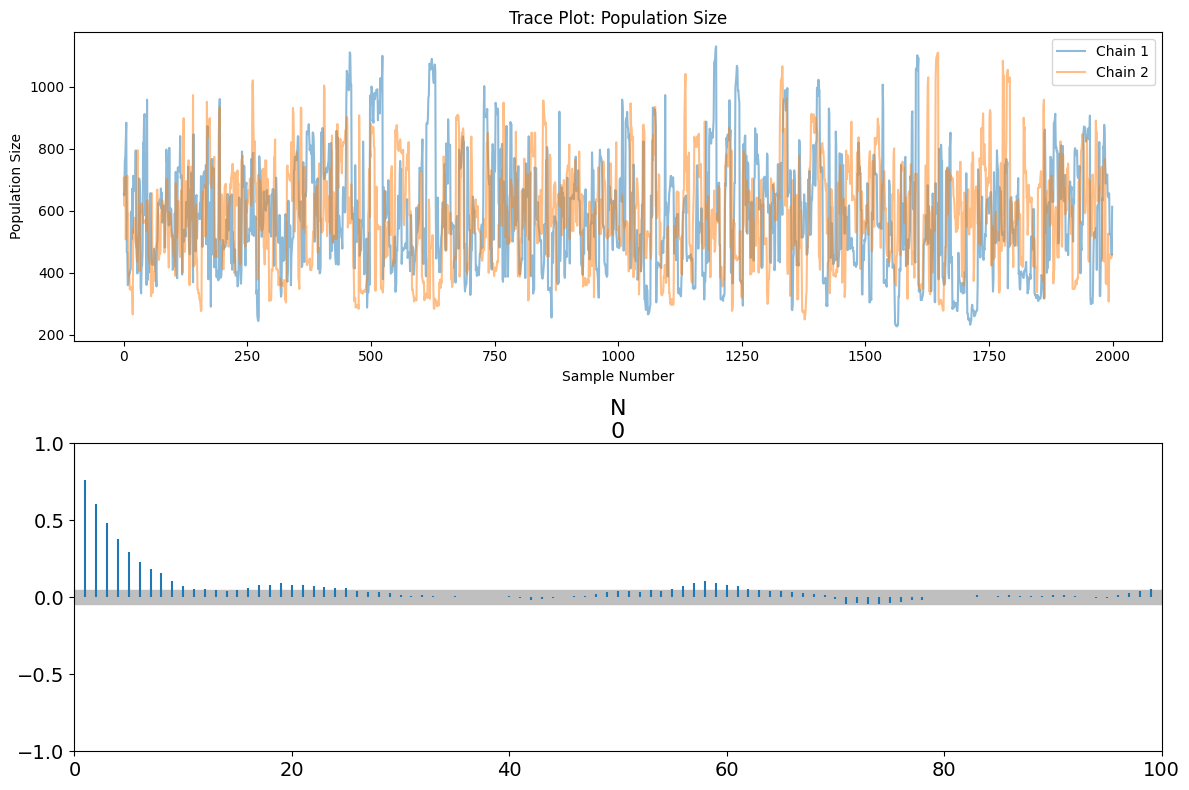

In [2]:
import numpy as np
import pymc as pm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import arviz as az  # Import arviz for analysis

# Generate some synthetic field data to simulate wildlife observations
np.random.seed(42)

# True population parameters (unknown in real life)
true_population = 500
detection_probability = 0.3

# Simulate field surveys over 10 days
n_surveys = 10
observed_counts = stats.binom.rvs(
    n=true_population, p=detection_probability, size=n_surveys
)

# Create a Bayesian model for population estimation
def create_population_model(observed_data):
    """
    Creates a hierarchical Bayesian model for population estimation
    using capture-recapture data.
    """
    with pm.Model() as population_model:
        # Prior for population size (we expect 100-1000 animals)
        population_size = pm.TruncatedNormal(
            "N", mu=600, sigma=200, lower=0  # Prior guess  # Prior uncertainty
        )

        # Prior for detection probability (between 0 and 1)
        detect_prob = pm.Beta(
            "p", alpha=2, beta=4  # Prior parameters suggesting  # probability around 0.2-0.4
        )

        # Likelihood of observations
        # Each survey is a binomial sample from true population
        observations = pm.Binomial(
            "obs", n=population_size, p=detect_prob, observed=observed_data
        )

        return population_model


# Create and run the model
with create_population_model(observed_counts) as model:
    # Provide explicit initial values to avoid potential issues with find_MAP
    initvals = {'N': 500, 'p': 0.3} # Initial guesses close to true values
    # Run MCMC sampling with initial values
    trace = pm.sample(
        2000,  # Number of samples
        tune=1000,  # Number of tuning steps
        return_inferencedata=True,
        target_accept=0.95,
        initvals=initvals,  # Use the initial values
    )

# Function to analyze and visualize results
def analyze_results(trace, true_pop, true_detect):
    """
    Analyze MCMC results and create visualizations
    """
    # Extract posterior samples
    population_samples = trace.posterior["N"].values.flatten()
    detection_samples = trace.posterior["p"].values.flatten()

    # Calculate key statistics
    pop_estimate = np.mean(population_samples)
    pop_ci = np.percentile(population_samples, [2.5, 97.5])
    detect_estimate = np.mean(detection_samples)
    detect_ci = np.percentile(detection_samples, [2.5, 97.5])

    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Population size posterior
    sns.histplot(population_samples, ax=ax1, stat="density")
    ax1.axvline(true_pop, color="r", linestyle="--", label="True Value")
    ax1.axvline(pop_estimate, color="g", linestyle="-", label="Estimate")
    ax1.fill_between(
        [pop_ci[0], pop_ci[1]], 0, 0.01, alpha=0.3, color="g", label="95% CI"
    )
    ax1.set_title("Posterior Distribution: Population Size")
    ax1.legend()

    # Detection probability posterior
    sns.histplot(detection_samples, ax=ax2, stat='density')
    ax2.axvline(true_detect, color='r', linestyle='--', label='True Value')
    ax2.axvline(detect_estimate, color='g', linestyle='-', label='Estimate')
    ax2.fill_between([detect_ci[0], detect_ci[1]],
                    0,
                    10,
                    alpha=0.3,
                    color='g',
                    label='95% CI')
    ax2.set_title('Posterior Distribution: Detection Probability')
    ax2.legend()

    plt.tight_layout()

    # Print summary statistics
    print("\nResults Summary:")
    print(f"True Population Size: {true_pop}")
    print(f"Estimated Population Size: {pop_estimate:.1f}")
    print(f"95% CI: ({pop_ci[0]:.1f}, {pop_ci[1]:.1f})")
    print(f"\nTrue Detection Probability: {true_detect:.2f}")
    print(f"Estimated Detection Probability: {detect_estimate:.2f}")
    print(f"95% CI: ({detect_ci[0]:.2f}, {detect_ci[1]:.2f})")

    return fig

# Analyze results
analysis_plot = analyze_results(trace, true_population, detection_probability)

# Function to perform model diagnostics
def diagnostic_plots(trace):
    """
    Create diagnostic plots for MCMC convergence
    """
    # Extract chain values for population size
    chain_values = trace.posterior['N'].values

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Trace plot
    for chain in range(chain_values.shape[0]):
        ax1.plot(chain_values[chain, :], alpha=0.5,
                label=f'Chain {chain+1}')
    ax1.set_title('Trace Plot: Population Size')
    ax1.set_xlabel('Sample Number')
    ax1.set_ylabel('Population Size')
    ax1.legend()

    # Autocorrelation plot
    pm.plot_autocorr(trace, var_names=['N'], ax=ax2)

    plt.tight_layout()
    return fig

# Create diagnostic plots
diagnostic_plot = diagnostic_plots(trace)